In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import torch

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_pca(spectr, gt_map, class_labels):

    np.random.seed(0)
    N = spectr[np.where(gt_map.asarray()[:,:,0] == 1)]
    T = spectr[np.where(gt_map.asarray()[:,:,0] == 2)]
    B = spectr[np.where(gt_map.asarray()[:,:,0] == 3)]

    # select random samples from each class such that the number of samples is equal to the smallest class or max_samples
    nsamples = min(N.shape[0], T.shape[0], B.shape[0])

    idx_N = np.random.choice(N.shape[0], nsamples, replace=False)
    N = N[idx_N]
    idx_T = np.random.choice(T.shape[0], nsamples, replace=False)
    T = T[idx_T]
    idx_B = np.random.choice(B.shape[0], nsamples, replace=False)
    B = B[idx_B]

    NTB = np.concatenate((N, T, B))

    pca = PCA(n_components=2)
    NTB_pca = pca.fit_transform(NTB)


    tsne = TSNE(n_components=2)
    NTB_tsne = tsne.fit_transform(NTB)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    Y = np.repeat([1, 2, 3], nsamples)
    for i in range(1,4):
        axs[0].scatter(NTB_tsne[Y==i, 0], NTB_tsne[Y==i, 1], label=class_labels[i])
        axs[1].scatter(NTB_pca[Y==i, 0], NTB_pca[Y==i, 1], label=class_labels[i])
    axs[0].set_title('t-SNE')
    axs[1].set_title('PCA')
    axs[1].legend()


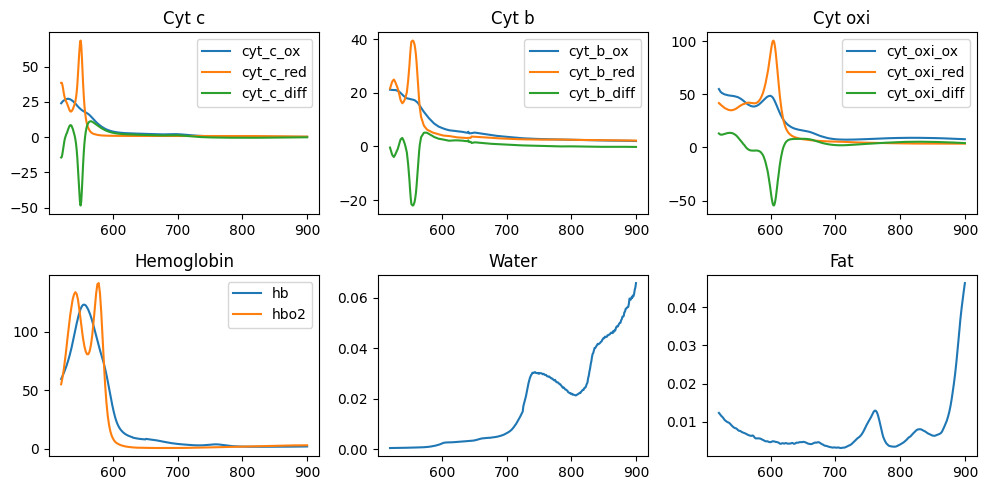

In [3]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
ones = np.ones_like(water)

# Plot the extinctions
fig, axs = plt.subplots(2,3, figsize=(10,5))   
for name, extinction in extinction_dict.items():
    if "cyt_c" in name:
        axs[0,0].plot(band_centers, extinction, label=name)
    elif "cyt_b" in name: 
        axs[0,1].plot(band_centers, extinction, label=name)
    elif "cyt_oxi" in name: 
        axs[0,2].plot(band_centers, extinction, label=name)
    elif name == "hb":
        axs[1,0].plot(band_centers, extinction, label=name)
    elif name == "hbo2":
        axs[1,0].plot(band_centers, extinction, label=name)
    elif name == "water":
        axs[1,1].plot(band_centers, extinction, label=name)
    elif name == "fat":
        axs[1,2].plot(band_centers, extinction, label=name)
axs[0,0].set_title("Cyt c")
axs[0,1].set_title("Cyt b")
axs[0,2].set_title("Cyt oxi")
axs[1,0].set_title("Hemoglobin")
axs[1,1].set_title("Water")
axs[1,2].set_title("Fat")
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
plt.tight_layout()


# remove cytochrome difference spectra as they are not needed for helicoid
_ = extinction_dict.pop("cyt_c_diff")
_ = extinction_dict.pop("cyt_b_diff")
_ = extinction_dict.pop("cyt_oxi_diff")


endmember_labels = ["Cyt c ox", "Cyt c red", "Cyt b ox", "Cyt b red", "Cyt oxi ox", "Cyt oxi red", "Hb", "HbO2", "Water", "Fat"]
extinction_array = np.vstack([extinction_dict[key] for key in extinction_dict.keys()])

extinction_array_ones = np.vstack([extinction_array, ones])

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


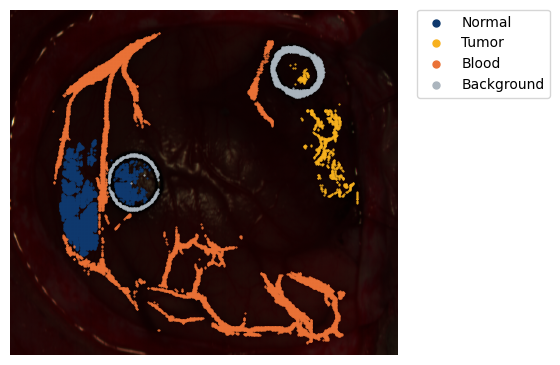

In [4]:
data_folder = "../../datasets/helicoid/012-01"
class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)


img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_smooth = smooth_spectral(img_calib, 5)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
# absorbance = -np.log(img_calib_norm - np.min(img_calib_norm.flatten()) + 1e-8)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

# fig, axs = plot_class_spectra(img, gt_map, nspectr=20, bands=img.bands.centers)
# fig.suptitle("Raw image")
# fig, axs = plot_class_spectra(img_interp, gt_map, nspectr=20, bands=band_centers)
# fig.suptitle("Interpolated image")
# fig, axs = plot_class_spectra(img_calib, gt_map, nspectr=20, bands=band_centers)
# fig.suptitle("Calibrated image")
# fig, axs = plot_class_spectra(img_smooth, gt_map, nspectr=20, bands=band_centers)
# fig.suptitle("Smoothed image")
# fig, axs = plot_class_spectra(absorbance, gt_map, nspectr=20, bands=band_centers)
# fig.suptitle("Absorbance image")

In [5]:
def cosine_similarity(abs, spectr):
    return np.einsum("...k,k->...", abs, spectr) / (np.linalg.norm(abs, axis=2) * np.linalg.norm(spectr))

def similarity(abs, spectr):
    return np.einsum("...k,k->...", abs, spectr)

In [6]:
def project_lin_iterative(abs, endmembers_proj, endmembers_unmix, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        abs: absorbance array to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected absorbance array perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''
    n,k = endmembers_proj.shape
    # convert to torch tensors
    abs = torch.from_numpy(abs).to(device).float()
    endmembers_proj = torch.from_numpy(endmembers_proj).to(device).float()
    endmembers_unmix = torch.from_numpy(endmembers_unmix).to(device).float()
    for i in range(n):
        # construct projection matrix onto orthogonal complement of current endmember
        endmember_proj = endmembers_proj[i,:]
        P = torch.eye(k).to(device) - torch.outer(endmember_proj, endmember_proj)/torch.dot(endmember_proj, endmember_proj)
        # apply mapping to data
        abs = torch.einsum('ik,...k->...i', P, abs)
        endmembers_unmix = torch.einsum('ik,nk->ni', P, endmembers_unmix)
        endmembers_proj = torch.einsum('ik,nk->ni', P, endmembers_proj)
    # convert back to numpy array
    abs_proj = abs.cpu().numpy()
    endmembers_unmix_proj = endmembers_unmix.cpu().numpy()
    return abs_proj, endmembers_unmix_proj

def project_lin_pinv(abs, endmembers_proj, endmembers_unmix, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        abs: absorbance array to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected absorbance array perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''
    P = np.eye(endmembers_proj.shape[1]) - endmembers_proj.T @ np.linalg.pinv(endmembers_proj).T
    # convert to torch tensors
    P = torch.from_numpy(P).to(device).float()
    abs = torch.from_numpy(abs).to(device).float()
    endmembers_unmix = torch.from_numpy(endmembers_unmix).to(device).float()
    # project data
    abs_proj = torch.einsum('ik,...k->...i', P, abs).cpu().numpy()
    endmembers_unmix_proj = torch.einsum('ik,nk->ni', P, endmembers_unmix).cpu().numpy()
    return abs_proj, endmembers_unmix_proj

def project_lin_fast(abs, endmembers_proj, endmembers_unmix, device="cpu"):
    '''
    Project the image onto the subspace orthogonal to the spectra.
    input:
        abs: absorbance array to project, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        endmembers: endmember spectra, shape (n, k), where n is the number of endmembers
    output:
        projected absorbance array perpendicular to all spectra, np.array
        projected endmembers_unmix, np.array
    '''
    # construct projection matrix onto orthogonal complement of endmembers_proj
    endmembers_proj_orth = scipy.linalg.orth(endmembers_proj.T).T
    P = np.eye(endmembers_proj.shape[1]) - endmembers_proj_orth.T @ endmembers_proj_orth
    # convert to torch tensors
    P = torch.from_numpy(P).to(device).float()
    abs = torch.from_numpy(abs).to(device).float()
    endmembers_unmix = torch.from_numpy(endmembers_unmix).to(device).float()
    # project data
    abs_proj = torch.einsum('ik,...k->...i', P, abs).cpu().numpy()
    endmembers_unmix_proj = torch.einsum('ik,nk->ni', P, endmembers_unmix).cpu().numpy()
    return abs_proj, endmembers_unmix_proj

def distance_after_proj_iterative(absorbance, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    absorbance_proj, endmembers_unmix_proj = project_lin_iterative(absorbance, endmembers_proj, endmembers_unmix, device="cuda")
    d = cosine_similarity(absorbance_proj, endmembers_unmix_proj.squeeze())
    return d

def distance_after_proj_fast(absorbance, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    absorbance, endmembers_unmix_proj = project_lin_fast(absorbance, endmembers_proj, endmembers_unmix, device="cuda")
    d = cosine_similarity(absorbance, endmembers_unmix_proj.squeeze())
    return d

def distance_after_proj_pinv(absorbance, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    absorbance_proj, endmembers_unmix_proj = project_lin_pinv(absorbance, endmembers_proj, endmembers_unmix, device="cuda")
    d = cosine_similarity(absorbance_proj, endmembers_unmix_proj.squeeze())
    return d

def distance_after_proj_pinv2(absorbance, endmember_array, idx):
    endmembers_unmix = endmember_array[idx,:][None,:]
    endmembers_proj = np.delete(endmember_array, idx, axis=0)
    absorbance_proj, endmembers_unmix_proj = project_lin_pinv(absorbance, endmembers_proj, endmembers_unmix, device="cuda")
    d = similarity(absorbance_proj, endmembers_unmix.squeeze())
    return d

#### Cosine similarity without projection

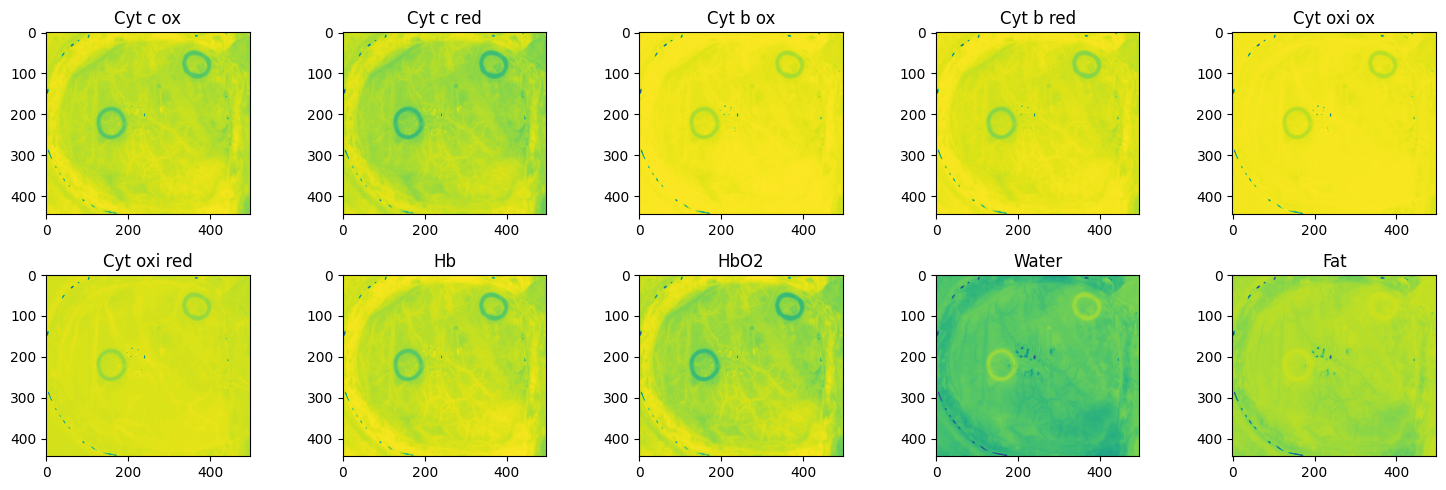

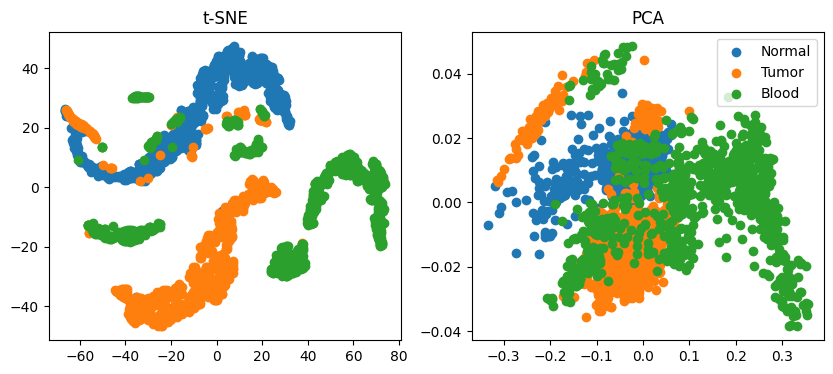

In [7]:
fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = cosine_similarity(absorbance, extinction_array[i,:])
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
plt.tight_layout()

plot_pca(data, gt_map, class_labels)

### Projection (1st order) + Cosine similarity

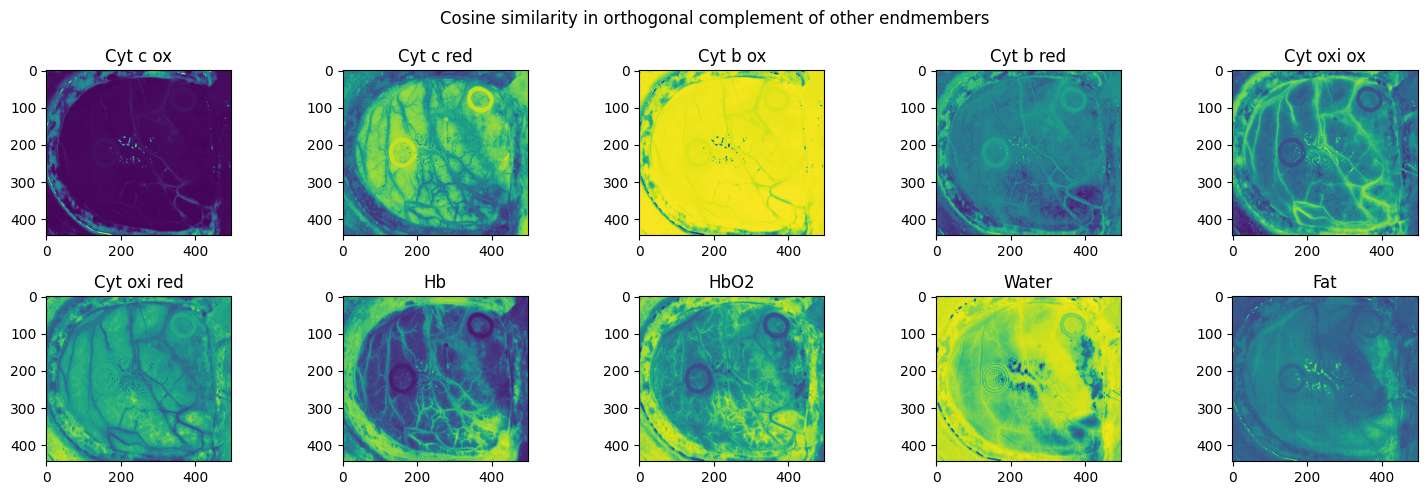

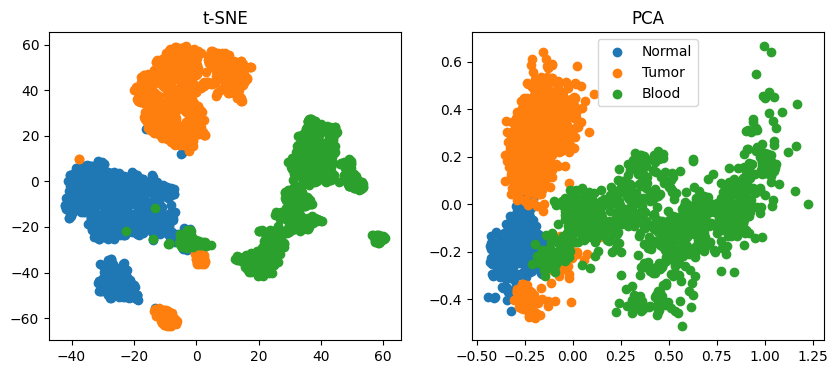

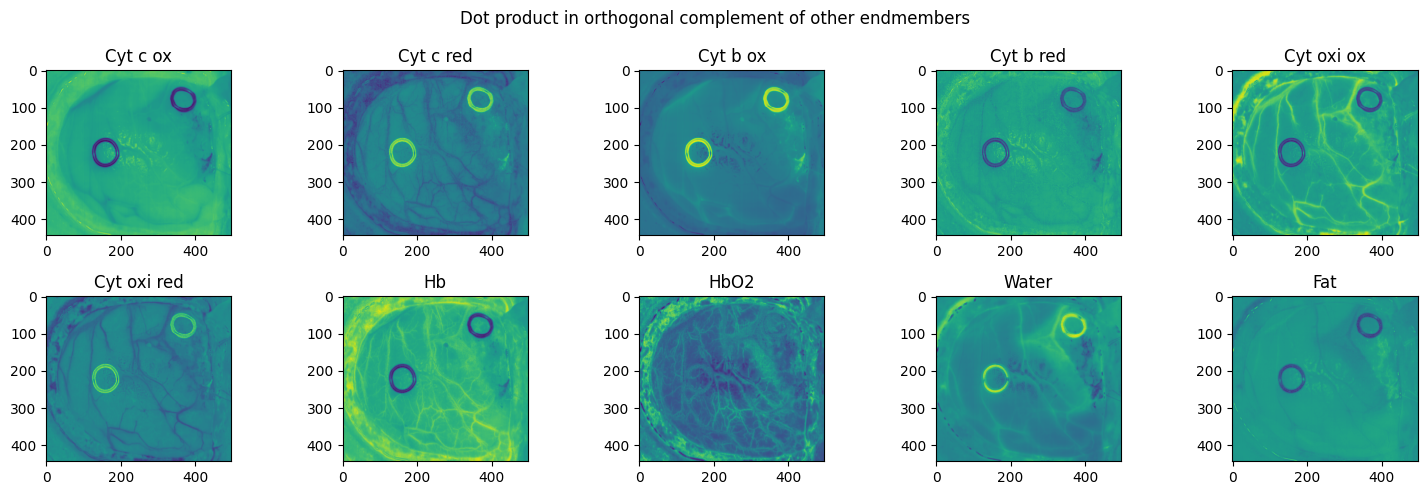

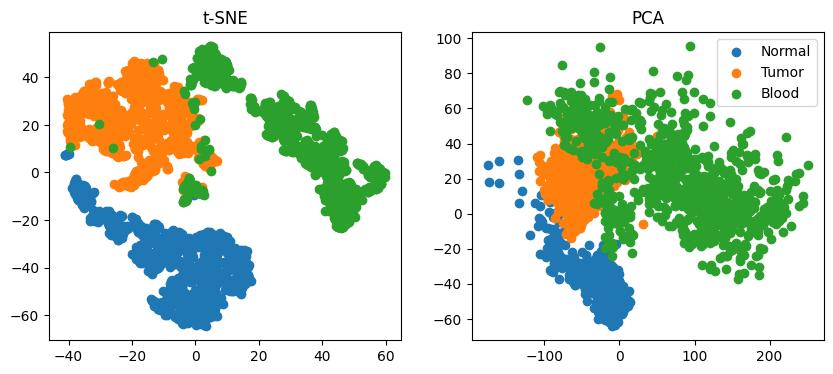

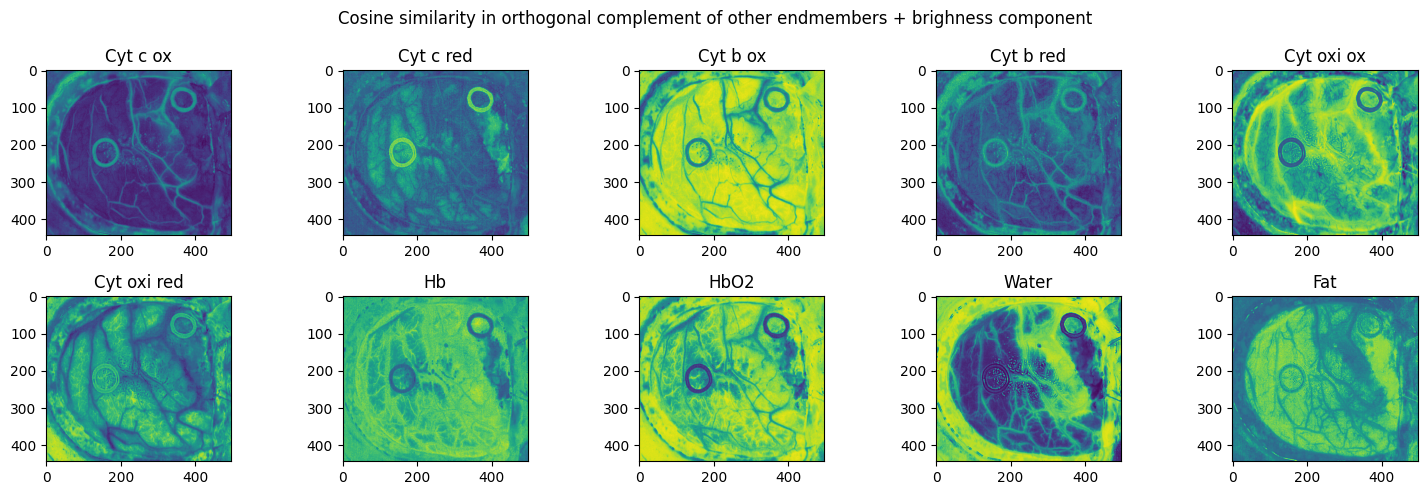

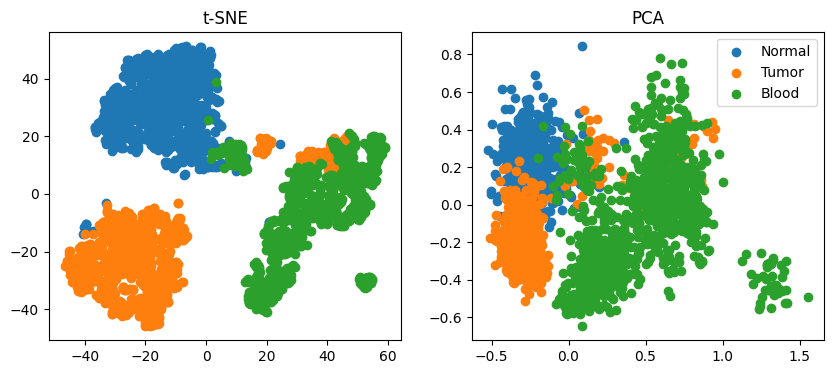

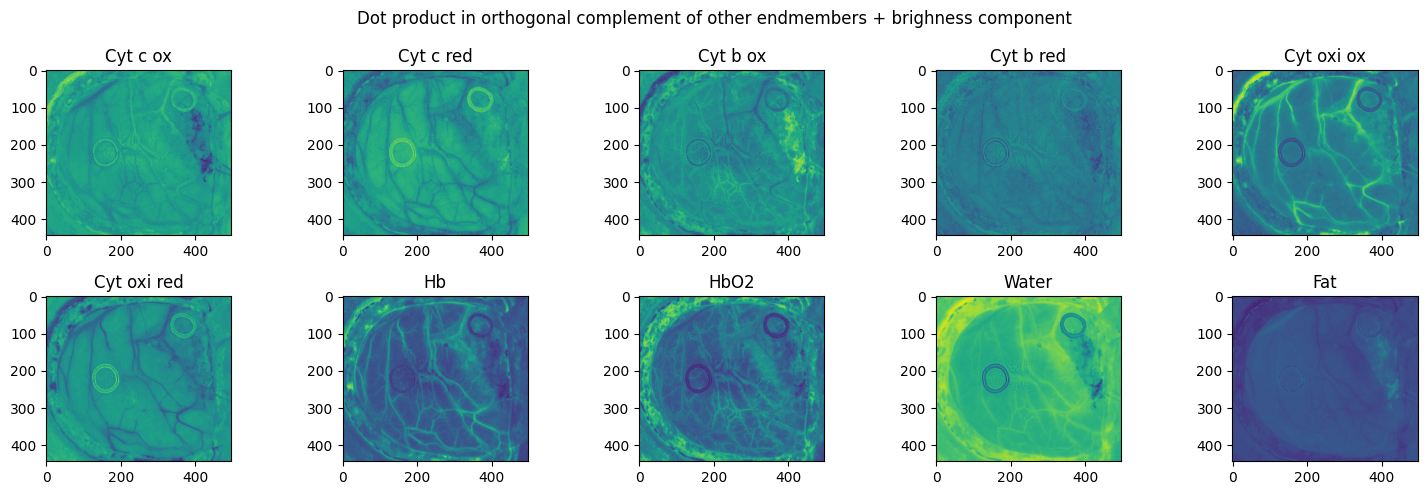

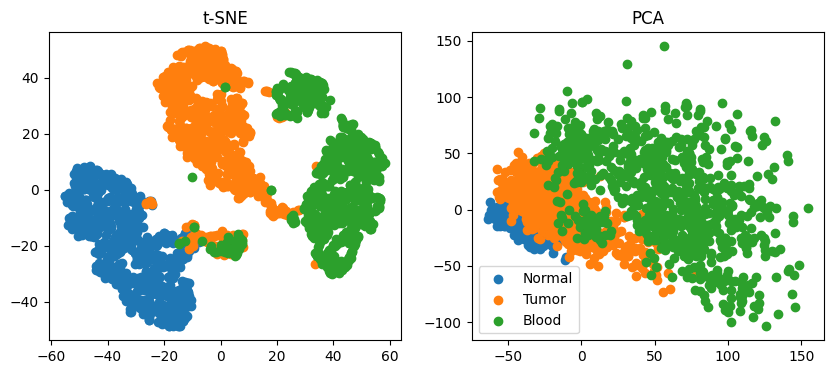

In [8]:
fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = distance_after_proj_pinv(absorbance, extinction_array, i)
    # d = scipy.ndimage.gaussian_filter(d, sigma=2)
    # axs[i//5,i%5].imshow(d, cmap='PiYG')
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
fig.suptitle("Cosine similarity in orthogonal complement of other endmembers")
plt.tight_layout()

plot_pca(data, gt_map, class_labels)


fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = distance_after_proj_pinv2(absorbance, extinction_array, i)
    # d = scipy.ndimage.gaussian_filter(d, sigma=2)
    # axs[i//5,i%5].imshow(d, cmap='PiYG')
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
fig.suptitle("Dot product in orthogonal complement of other endmembers")
plt.tight_layout()

plot_pca(data, gt_map, class_labels)


fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = distance_after_proj_pinv(absorbance, extinction_array_ones, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
fig.suptitle("Cosine similarity in orthogonal complement of other endmembers + brighness component")
plt.tight_layout()

plot_pca(data, gt_map, class_labels)

fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = distance_after_proj_pinv2(absorbance, extinction_array_ones, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
fig.suptitle("Dot product in orthogonal complement of other endmembers + brighness component")
plt.tight_layout()

plot_pca(data, gt_map, class_labels)


### Projection (2nd order) + Cosine similarity

In [10]:
n,k = extinction_array.shape
extinction_array_bilinear = np.zeros((int(n*(n+1)/2), k))
idx = 0
for i in range(n):
    for j in range(i,n):
        extinction_array_bilinear[idx,:] = extinction_array[i,:] * extinction_array[j,:]
        idx += 1

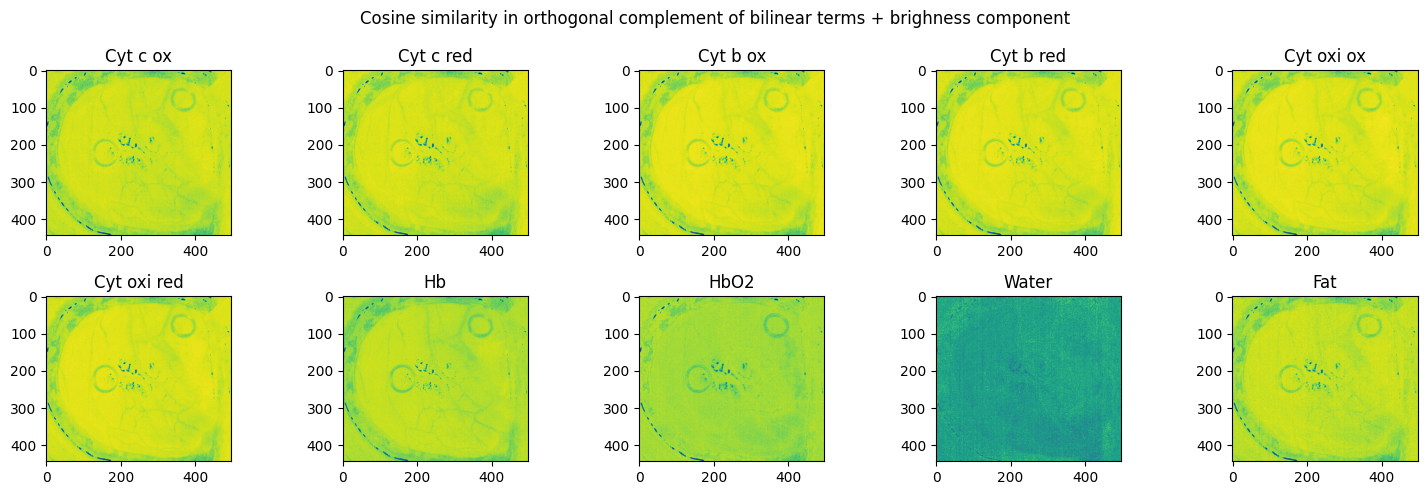

In [42]:
absorbance_proj, endmembers_unmix_proj = project_lin_fast(absorbance, endmembers_proj=extinction_array_bilinear, endmembers_unmix=extinction_array_ones , device="cuda")

fig, axs = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    d = cosine_similarity(absorbance_proj, endmembers_unmix_proj[i,:])
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
fig.suptitle("Cosine similarity in orthogonal complement of bilinear terms + brighness component")
plt.tight_layout()

### Projection (1st + 2nd order) + Projection

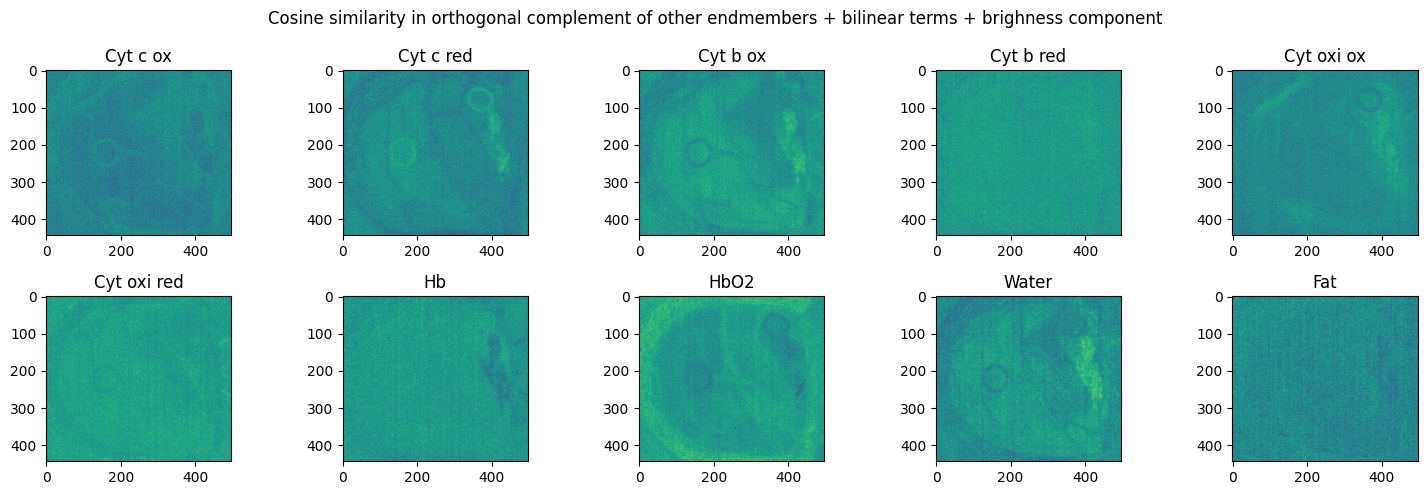

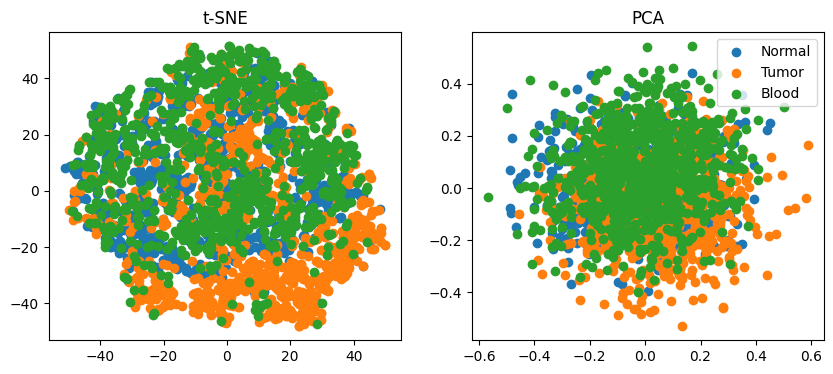

In [11]:
absorbance_proj, endmembers_unmix_proj = project_lin_pinv(absorbance, endmembers_proj=extinction_array_bilinear, endmembers_unmix=extinction_array_ones , device="cuda")

fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = distance_after_proj_pinv(absorbance_proj, endmembers_unmix_proj, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
fig.suptitle("Cosine similarity in orthogonal complement of other endmembers + bilinear terms + brighness component")
plt.tight_layout()

plot_pca(data, gt_map, class_labels)

Find spectra most correlated with spectrum of interest

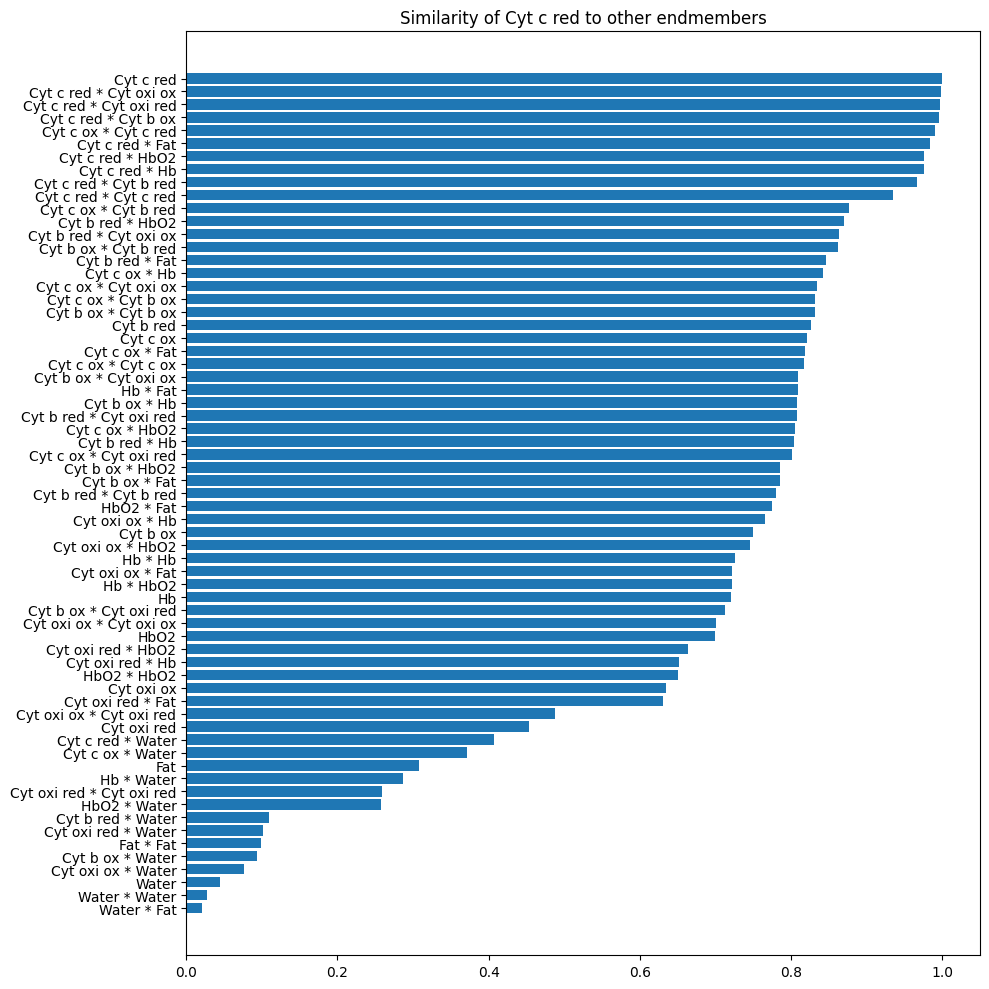

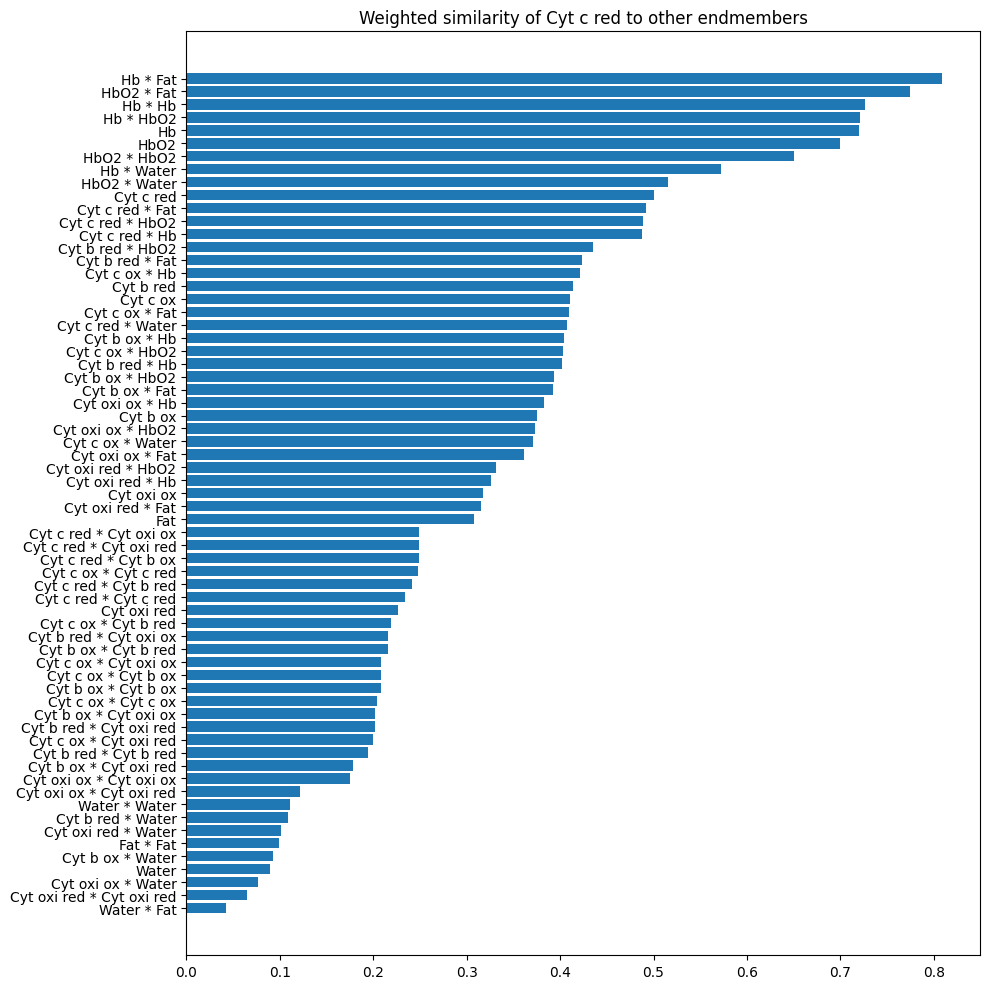

In [17]:
endmember_idx = 1

n = extinction_array.shape[0]
m = extinction_array[endmember_idx,:]

weights = np.ones(n)
weights = np.array([0.5,0.5,0.5,0.5,0.5,0.5,1,1,2,1])

similarity = np.zeros(n+int(n*(n+1)/2))
scale_factor = np.zeros(n+int(n*(n+1)/2))
labels = []
idx = 0
for i in range(n):
    similarity[idx] = m @ extinction_array[i,:]/ (np.linalg.norm(m) * np.linalg.norm(extinction_array[i,:]))
    scale_factor[idx] = weights[i]
    labels.append(endmember_labels[i])
    idx += 1
    for j in range(i,n):
        extinction_bilin = extinction_array[i,:] * extinction_array[j,:]
        similarity[idx] = m @ extinction_bilin/ (np.linalg.norm(m) * np.linalg.norm(extinction_bilin))
        scale_factor[idx] = weights[i] * weights[j]
        labels.append(endmember_labels[i] + " * " + endmember_labels[j])
        idx += 1

# unweighted
similarity_sorted = np.sort(similarity)
idx_sorted = np.argsort(similarity)
labels_sorted = [labels[i] for i in idx_sorted]

fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.barh(labels_sorted, similarity_sorted)
axs.set_title(f"Similarity of {endmember_labels[endmember_idx]} to other endmembers")
plt.tight_layout()

# weighted
similarity_sorted = np.sort(similarity * scale_factor)
idx_sorted = np.argsort(similarity * scale_factor)
labels_sorted = [labels[i] for i in idx_sorted]

fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.barh(labels_sorted, similarity_sorted)
axs.set_title(f"Weighted similarity of {endmember_labels[endmember_idx]} to other endmembers")
plt.tight_layout()

#### bilinear just for water

(443, 497, 10)


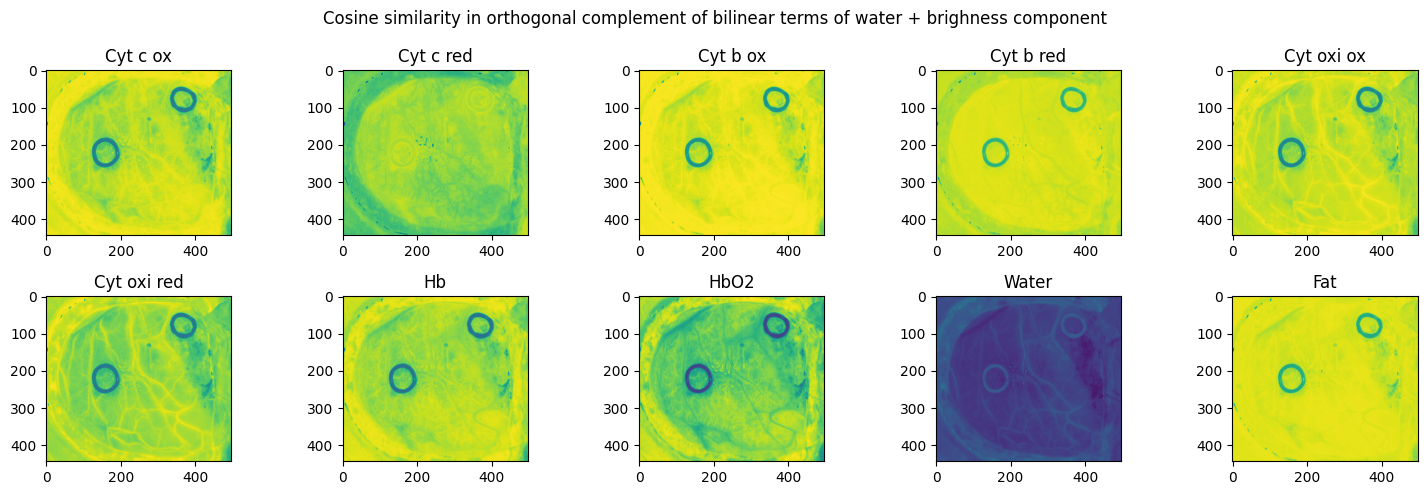

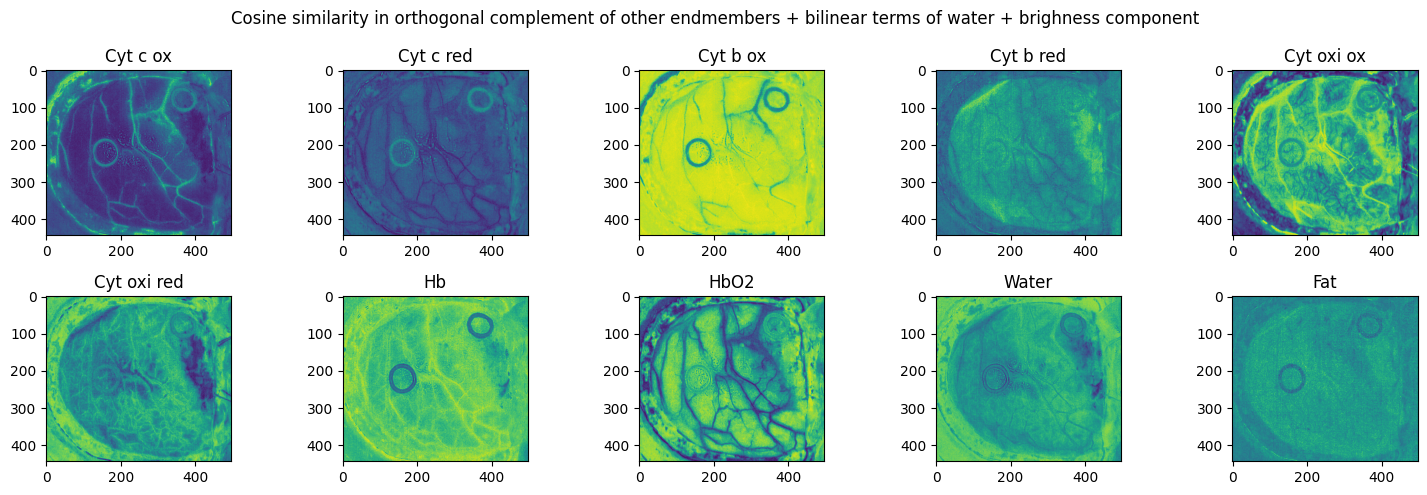

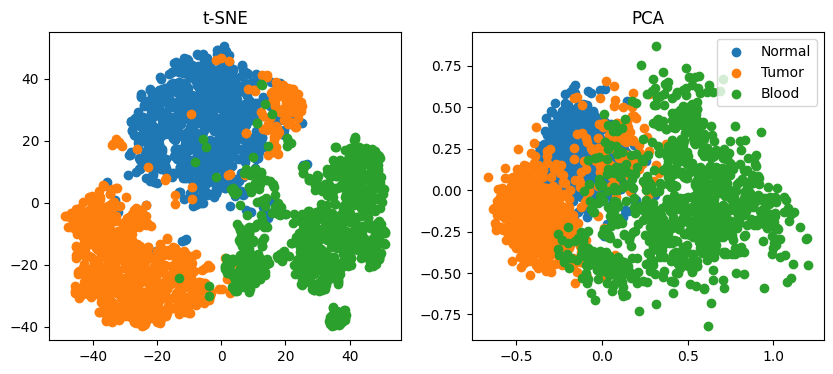

In [16]:
n,k = extinction_array.shape
extinction_array_bilinear_water = np.zeros((n, k))
for i in range(n):
        extinction_array_bilinear_water[i,:] = extinction_array[i,:] * water

# extinction_array_bilinear_water = smooth_spectral(extinction_array_bilinear_water, 10)
# plt.figure()
# plt.plot(np.log(extinction_array_bilinear_water.T))

absorbance_proj, endmembers_unmix_proj = project_lin_fast(absorbance, endmembers_proj=extinction_array_bilinear_water, endmembers_unmix=extinction_array_ones , device="cuda")

fig, axs = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    d = cosine_similarity(absorbance_proj, endmembers_unmix_proj[i,:])
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
fig.suptitle("Cosine similarity in orthogonal complement of bilinear terms of water + brighness component")
plt.tight_layout()

fig, axs = plt.subplots(2,5, figsize=(15,5))
data = np.zeros((absorbance.shape[0],absorbance.shape[1],10))
for i in range(10):
    d = distance_after_proj_fast(absorbance_proj, endmembers_unmix_proj, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
    data[:,:,i] = d
fig.suptitle("Cosine similarity in orthogonal complement of other endmembers + bilinear terms of water + brighness component")
plt.tight_layout()

print(data.shape)
plot_pca(data, gt_map, class_labels)

remove hb*hb02

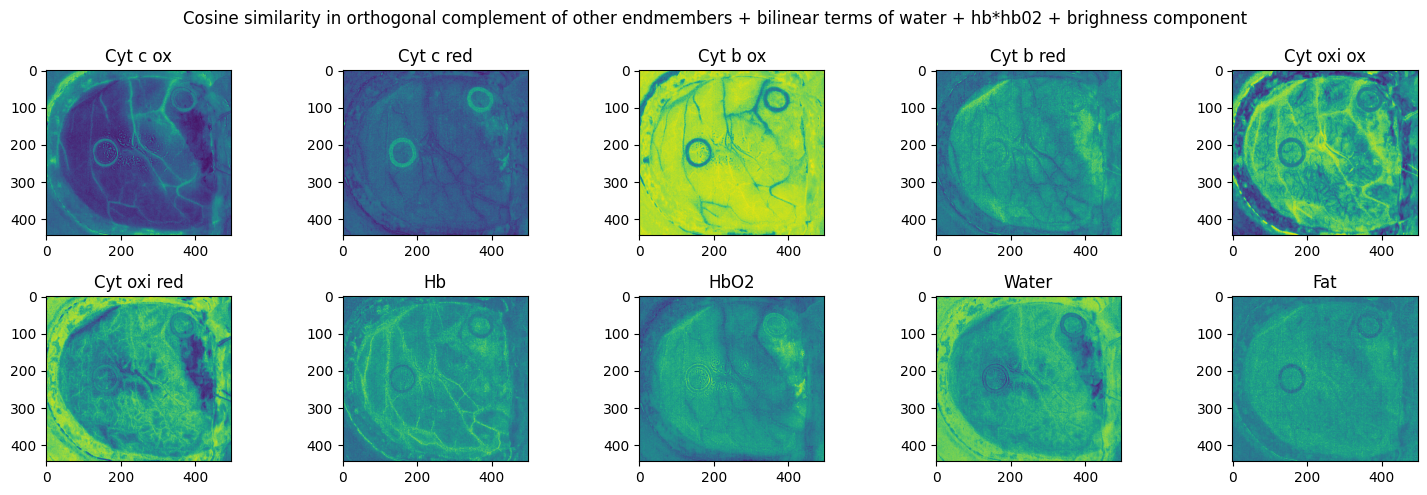

In [44]:
n,k = extinction_array.shape
extinction_array_bilinear_water = np.zeros((n+1, k))
for i in range(n):
        extinction_array_bilinear_water[i,:] = extinction_array[i,:] * water
extinction_array_bilinear_water[n,:] = hb * hbo2

# extinction_array_bilinear_water = smooth_spectral(extinction_array_bilinear_water, 10)
# plt.figure()
# plt.plot(np.log(extinction_array_bilinear_water.T))

absorbance_proj, endmembers_unmix_proj = project_lin_fast(absorbance, endmembers_proj=extinction_array_bilinear_water, endmembers_unmix=extinction_array_ones , device="cuda")

fig, axs = plt.subplots(2,5, figsize=(15,5))
for i in range(10):
    d = distance_after_proj_fast(absorbance_proj, endmembers_unmix_proj, i)
    axs[i//5,i%5].imshow(d)
    axs[i//5,i%5].set_title(endmember_labels[i])
fig.suptitle("Cosine similarity in orthogonal complement of other endmembers + bilinear terms of water + hb*hb02 + brighness component")
plt.tight_layout()